# Using `vlm-1` to understand financial presentations

In this notebook, we will use the `vlm-1` model to understand financial presentations. The NOS VLM-1 model is a vision-language model trained on a large corpus of financial documents. It is designed to understand the language used in financial documents and can be used to extract information from these documents.

As an example, we will use a dataset from the [SEC Edgar database](https://www.sec.gov/edgar.shtml) that contains financial presentations from various companies. We will use the NOS VLM-1 model to extract information from these presentations and analyze the data.

## 0. Setup

In [ ]:
# Install dependencies if needed
!pip install requests Pillow

## 1. `vlm` API

In this section, we will call the  `vlm-1` API using the Python `requests` library. We will use the `generate` endpoint of the API to extract visual information from the presentation slides.

Let's first test the `health` of the API.

In [22]:
import json
import os
import requests


VLM_BASE_URL = "https://vlm-dev.nos.run/v1"
response = requests.get(f"{VLM_BASE_URL}/health")
response.raise_for_status()
assert response.status_code == 200

## 2. List available models

Now, let's list the available models in the `vlm-1` API. If you are using the API for the first time, you may need to [sign up for an API key](typeform-link).

In [36]:
VLM_API_KEY = os.getenv("VLM_API_KEY", None)
if VLM_API_KEY is None:
    VLM_API_KEY = input()
print(f"Using API key: {VLM_API_KEY[:4]}...")

Using API key: sk-s...


In [37]:
headers = {
    "Content-Type": "application/json",
    "X-API-Key": VLM_API_KEY,
}
response = requests.get(f"{VLM_BASE_URL}/models", headers=headers)
response.raise_for_status()

In [24]:
print(json.dumps(response.json(), indent=2))

[
  {
    "model": "vlm-1",
    "domain": "tv.news"
  },
  {
    "model": "vlm-1",
    "domain": "web.youtube-screenshot"
  },
  {
    "model": "vlm-1",
    "domain": "document.presentation"
  }
]


As we can see, there are two models available with the same base model `vlm-1` and different specializated versions (or domain-specific versions), namely `tv.news` and `document.presentation` for TV news and financial presentation understanding, respectively.

## 3. Extract information from financial presentations

First, let's define some helper functions to extract information from the financial presentations.

In [25]:
import json
from io import BytesIO
from base64 import b64encode
from typing import Union, Literal
from pathlib import Path
from PIL import Image
from IPython.display import display


def pprint(data):
    print(json.dumps(data, indent=2))


def encode_image(
    image: Union[Image.Image, str, Path], format: Literal["PNG", "JPEG", "binary"] = "PNG"
) -> Union[str, bytes]:
    """Convert an image to a base64 string."""
    if isinstance(image, (str, Path)):
        if not Path(image).exists():
            raise FileNotFoundError(f"File not found {image}")
        image = Image.open(str(image)).convert("RGB")
    if isinstance(image, Image.Image):
        image = image.convert("RGB")

    buffered = BytesIO()
    if format == "binary":
        image.save(buffered, format="PNG")
        buffered.seek(0)
        return buffered.getvalue()

    image_format = image.format or format
    image.save(buffered, format=image_format)
    img_str = b64encode(buffered.getvalue()).decode()
    return f"data:image/{image_format.lower()};base64,{img_str}"


def download_image(url: str) -> Image.Image:
    """Download an image from a URL."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:106.0) Gecko/20100101 Firefox/106.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "DNT": "1",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
    }
    bytes = BytesIO(requests.get(url, headers=headers).content)
    bytes.seek(0)
    return Image.open(bytes).convert("RGB")


def vlm_1(image: Union[Image.Image, str, Path], domain: str, max_tokens: int = 1024):
    """Send an image to the VLM API."""
    assert domain in ("tv.news", "document.presentation")
    data = {
        "model": "vlm-1",
        "domain": domain,
        "image": encode_image(image),
    }
    response = requests.post(f"{VLM_BASE_URL}/generate", headers=headers, json=data)
    response.raise_for_status()
    return response.json()


def vlm_predict(image: Union[Image.Image, str, Path], domain: str, max_tokens: int = 1024):
    """Send an image to the VLM API and display the result."""
    if isinstance(image, str) and image.startswith("http"):
        image = download_image(image)
    elif isinstance(image, (str, Path)) and Path(image).exists():
        image = Image.open(image).convert("RGB")
    elif isinstance(image, Image.Image):
        image = image.convert("RGB")
    else:
        raise ValueError("Invalid image")

    display(image)
    result = vlm_1(image, domain, max_tokens=max_tokens)
    pprint(result)

Now, let's extract some information from a financial presentation on [SEC EDGAR](https://www.sec.gov/edgar/search-and-access).

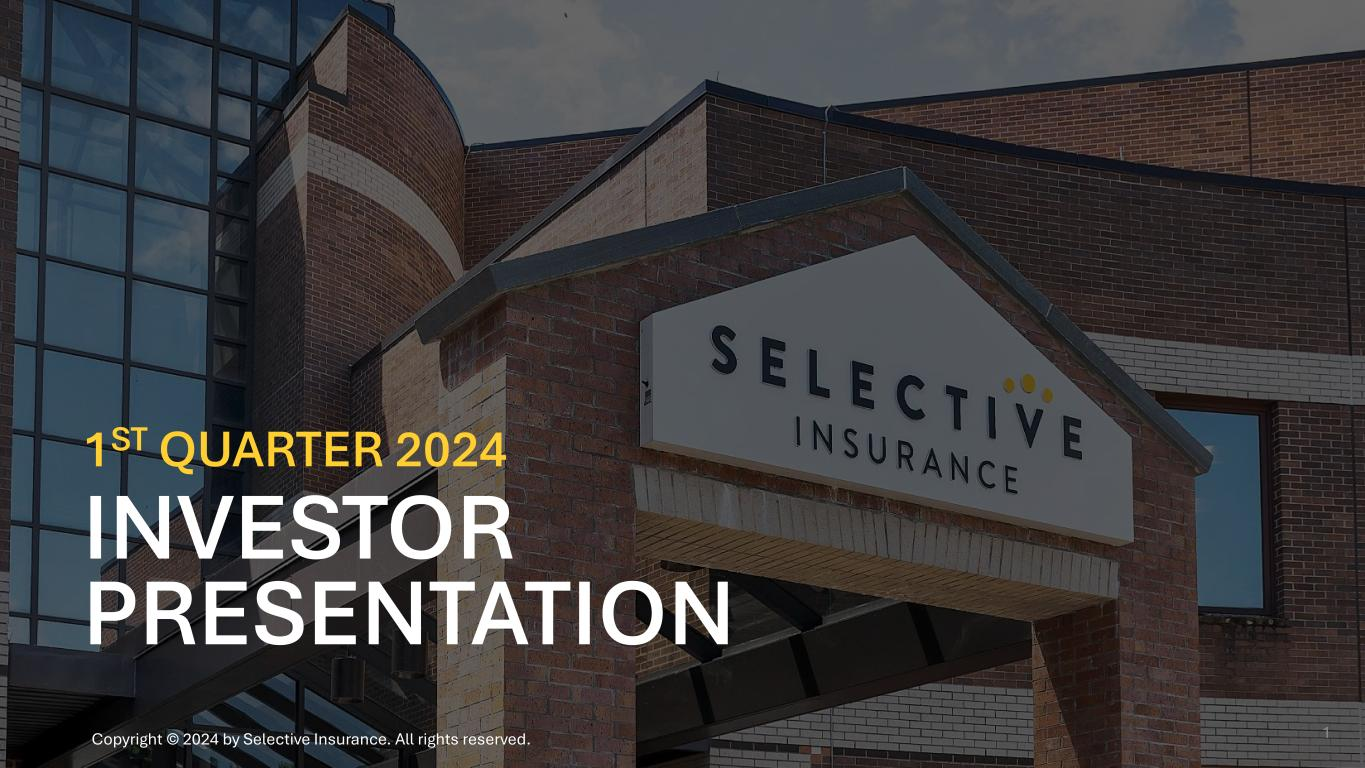

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide shows a building with a sign that reads 'SELECTIVE INSURANCE'. Overlaid text indicates that this is an 'INVESTOR PRESENTATION' for the '1ST QUARTER 2024'.",
  "title": "1ST QUARTER 2024 INVESTOR PRESENTATION",
  "page_number": null,
  "plots": null,
  "tables": null,
  "others": [
    {
      "cls_name": "MarkdownBlock",
      "markdown": "![Selective Insurance building](image) \n\n# 1ST QUARTER 2024 \n\n## INVESTOR PRESENTATION",
      "caption": null,
      "title": null
    }
  ]
}


In [26]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve001.jpg"
vlm_predict(url, "document.presentation")

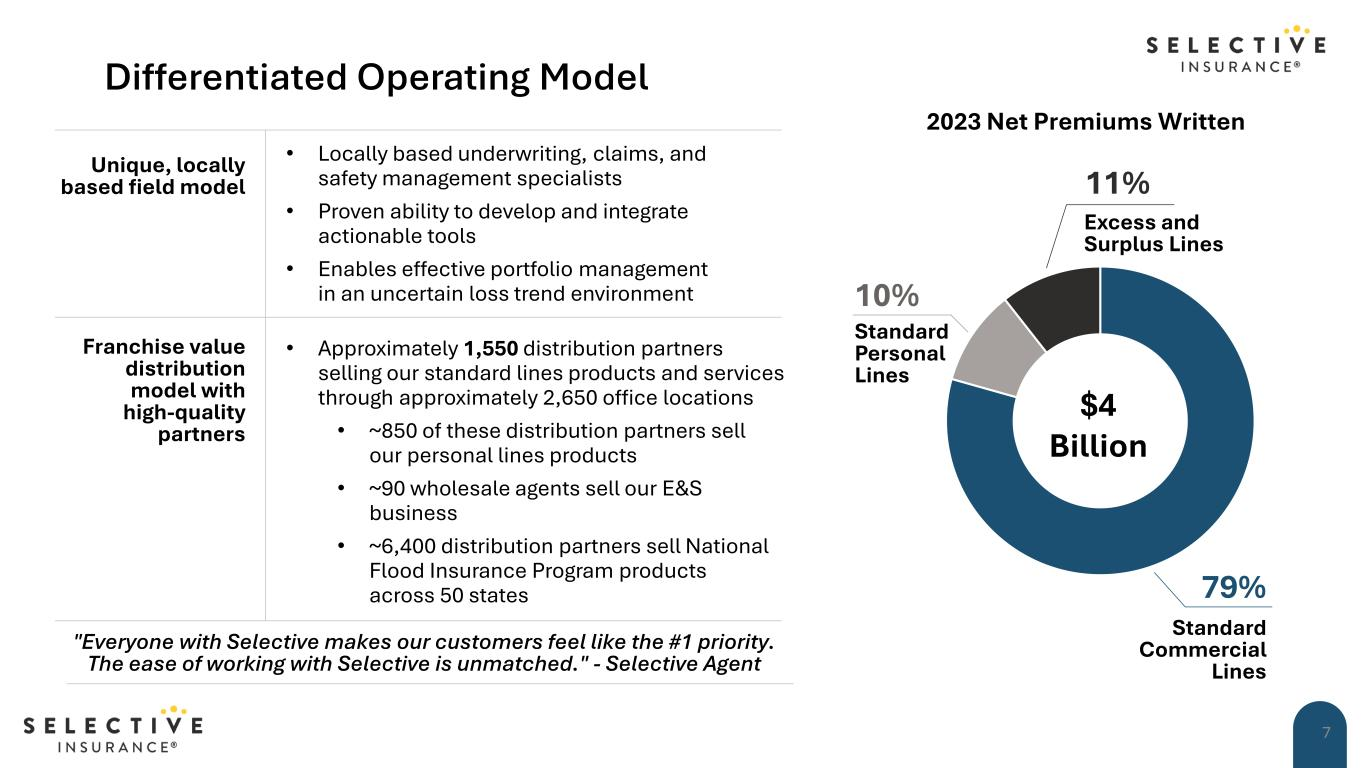

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents a 'Differentiated Operating Model' for Selective Insurance, detailing their unique field model, franchise value distribution, and a pie chart showing the 2023 Net Premiums Written with a total of $4 Billion distributed across different lines of insurance.",
  "title": "Differentiated Operating Model",
  "page_number": 7,
  "plots": [
    {
      "cls_name": "Plot",
      "type": "pie",
      "title": "2023 Net Premiums Written",
      "description": "A pie chart showing the distribution of net premiums written by Selective Insurance in 2023, totaling $4 Billion. It is divided into three categories: Standard Commercial Lines (79%), Standard Personal Lines (10%), and Excess and Surplus Lines (11%).",
      "markdown": "| Category | Percentage | \n| --- | --- | \n| Standard Commercial Lines | 79% | \n| Standard Personal Lines | 10% | \n| Excess and Surplus Lines | 11% |",
      "caption": null
    }
  ],
  "tables":

In [27]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve007.jpg"
vlm_predict(url, "document.presentation")

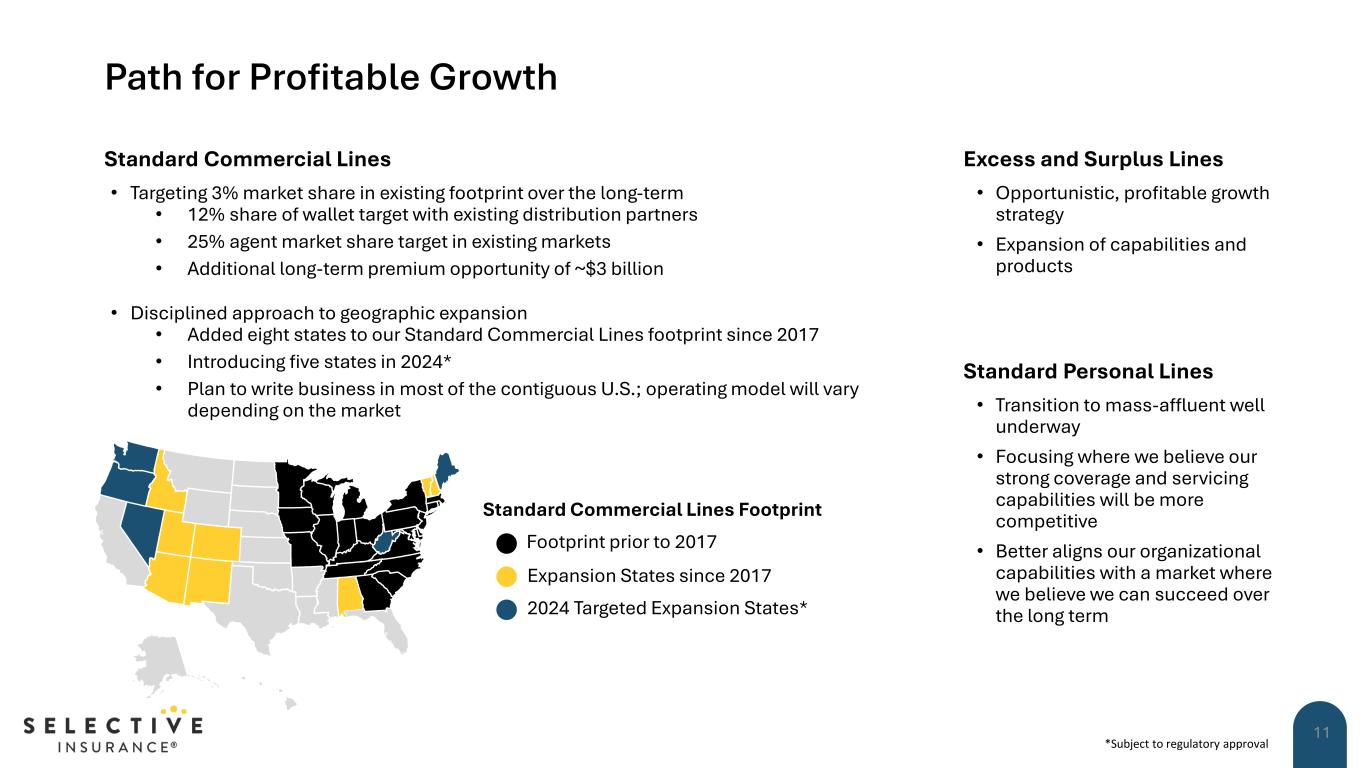

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents a strategic overview titled 'Path for Profitable Growth' for an insurance company. It outlines the company's growth plans in three different lines of business: Standard Commercial Lines, Excess and Surplus Lines, and Standard Personal Lines. The slide includes a map of the United States highlighting the company's geographic expansion in commercial lines.",
  "title": "Path for Profitable Growth",
  "page_number": 11,
  "plots": null,
  "tables": null,
  "others": [
    {
      "cls_name": "MarkdownBlock",
      "markdown": "### Standard Commercial Lines\n- Targeting 3% market share in existing footprint over the long-term\n  - 12% share of wallet target with existing distribution partners\n  - 25% agent market share target in existing markets\n  - Additional long-term premium opportunity of ~$3 billion\n- Disciplined approach to geographic expansion\n  - Added eight states to our Standard Commercial Lines footpri

In [28]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve011.jpg"
vlm_predict(url, "document.presentation")

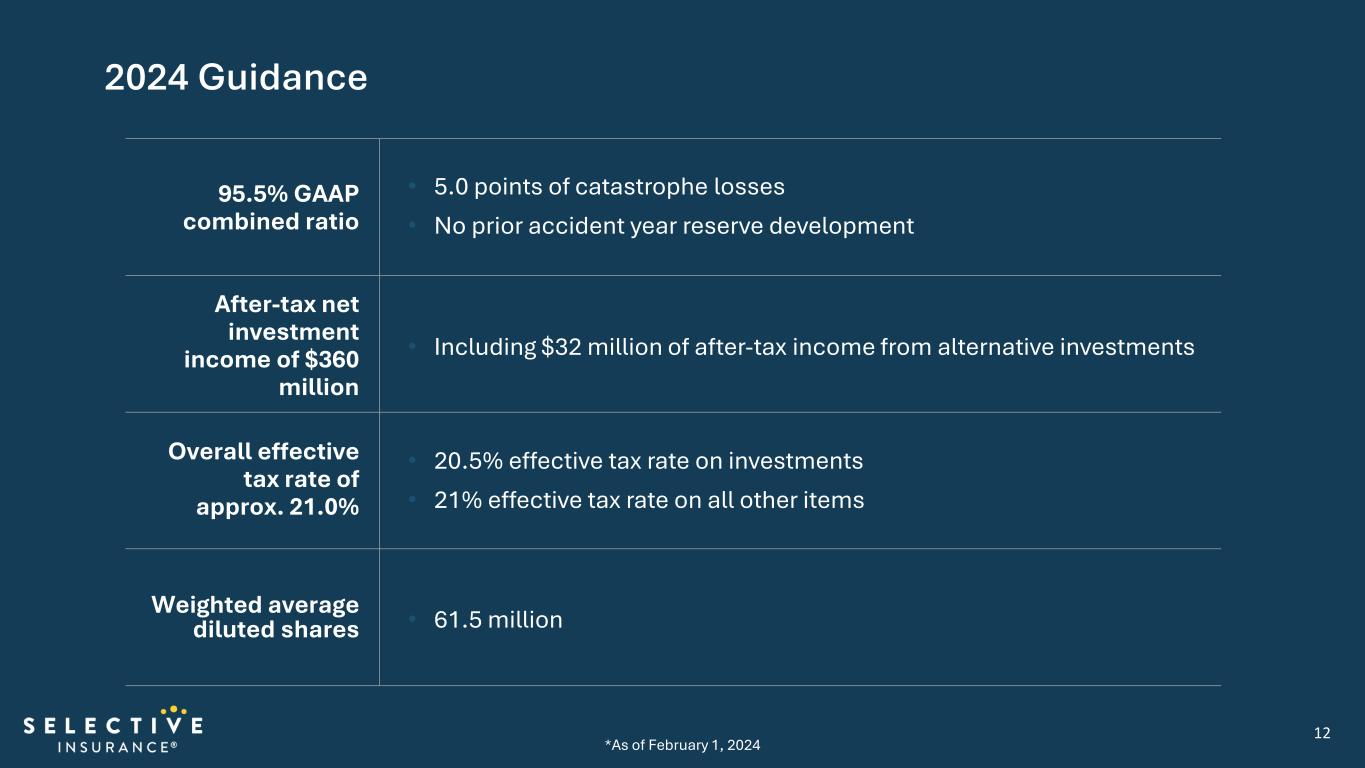

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents the 2024 Guidance for Selective Insurance, detailing key financial metrics and projections.",
  "title": "2024 Guidance",
  "page_number": 12,
  "plots": null,
  "tables": null,
  "others": [
    {
      "cls_name": "MarkdownBlock",
      "markdown": "### 2024 Guidance\n\n- **95.5% GAAP combined ratio**\n- **After-tax net investment income of $360 million**\n- **Overall effective tax rate of approx. 21.0%**\n- **Weighted average diluted shares: 61.5 million**\n- **5.0 points of catastrophe losses**\n- **No prior accident year reserve development**\n- **Including $32 million of after-tax income from alternative investments**\n- **20.5% effective tax rate on investments**\n- **21% effective tax rate on all other items**\n\n*As of February 1, 2024*",
      "caption": null,
      "title": null
    }
  ]
}


In [29]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve012.jpg"
vlm_predict(url, "document.presentation")

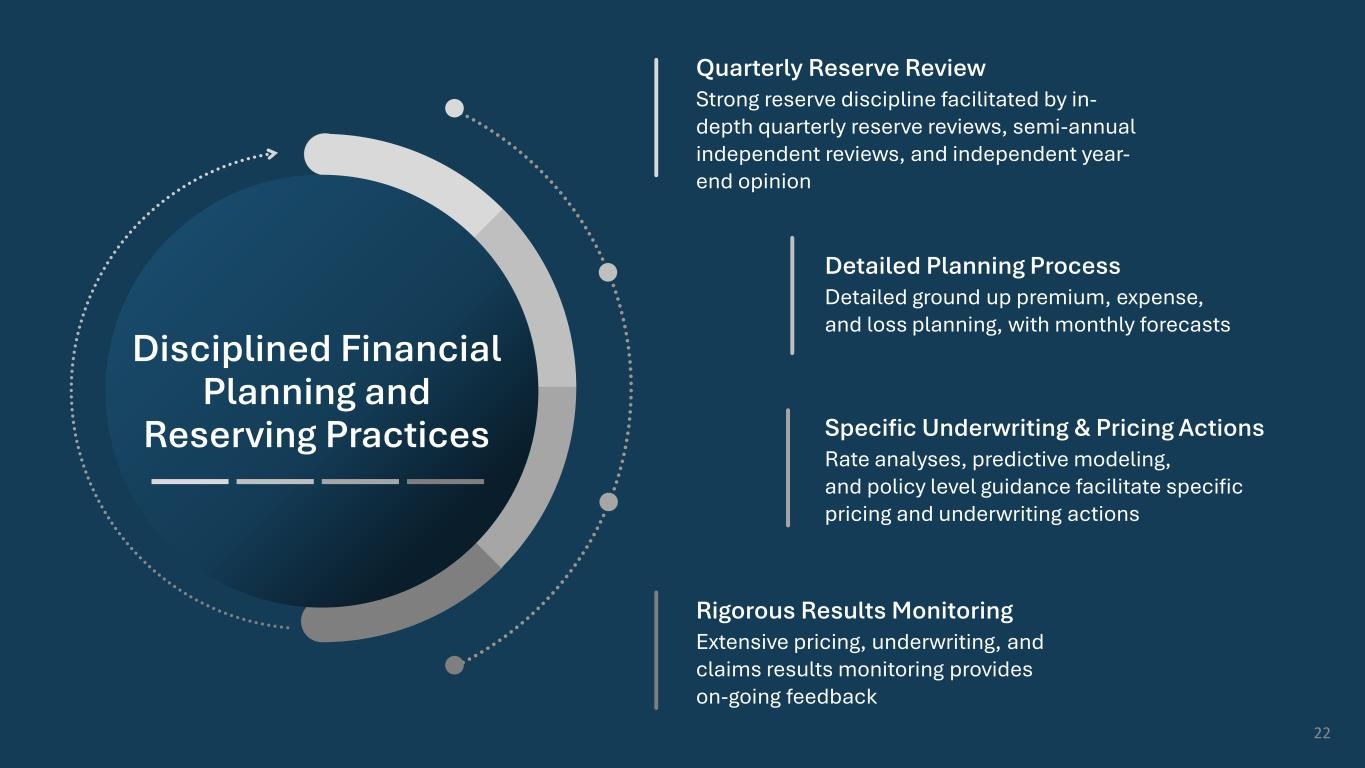

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents a circular flow diagram with four segments, each containing a heading and a brief description. The segments are connected by a dotted line that flows clockwise. The overall theme is related to financial planning and reserving practices.",
  "title": "Disciplined Financial Planning and Reserving Practices",
  "page_number": 22,
  "plots": null,
  "tables": null,
  "others": [
    {
      "cls_name": "MarkdownBlock",
      "markdown": "### Disciplined Financial Planning and Reserving Practices\n\n- **Quarterly Reserve Review**\n  Strong reserve discipline facilitated by in-depth quarterly reserve reviews, semi-annual independent reviews, and independent year-end opinion.\n\n- **Detailed Planning Process**\n  Detailed ground up premium, expense, and loss planning, with monthly forecasts.\n\n- **Specific Underwriting & Pricing Actions**\n  Rate analyses, predictive modeling, and policy level guidance facilitate speci

In [30]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve022.jpg"
vlm_predict(url, "document.presentation")

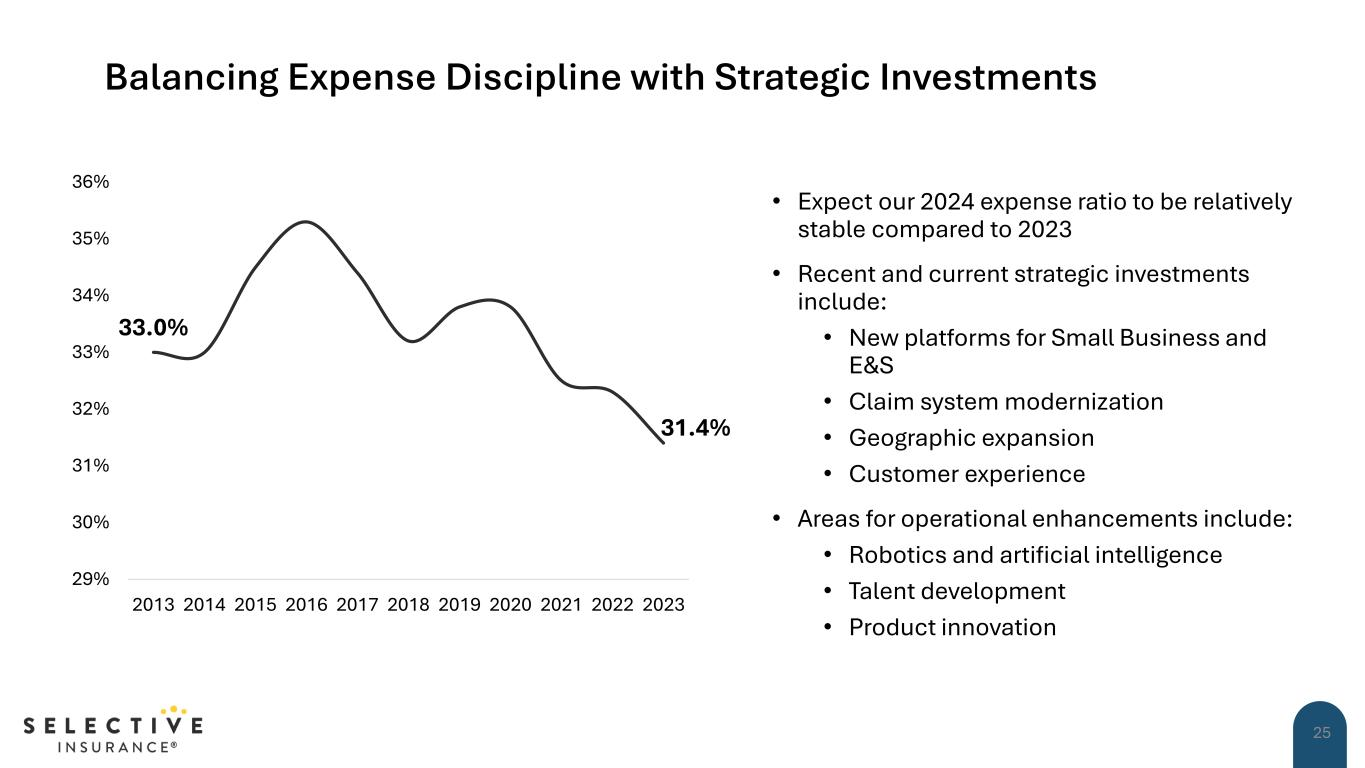

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents a line graph on the left side, showing a trend over time from 2013 to 2023 with specific percentage values highlighted for 2013 and 2023. On the right side, there is a bulleted list of points related to expense discipline and strategic investments.",
  "title": "Balancing Expense Discipline with Strategic Investments",
  "page_number": 25,
  "plots": [
    {
      "cls_name": "Plot",
      "type": "line",
      "title": null,
      "description": "A line graph showing a trend over time with percentage values on the y-axis ranging from 29% to 36% and years from 2013 to 2023 on the x-axis. The graph indicates a percentage value of 33.0% for 2013 and 31.4% for 2023.",
      "markdown": "Year | Percentage\n--- | ---\n2013 | 33.0%\n2014 | \n2015 | \n2016 | \n2017 | \n2018 | \n2019 | \n2020 | \n2021 | \n2022 | \n2023 | 31.4%",
      "caption": null
    }
  ],
  "tables": null,
  "others": [
    {
      "cls_name": "Mar

In [31]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve025.jpg"
vlm_predict(url, "document.presentation")

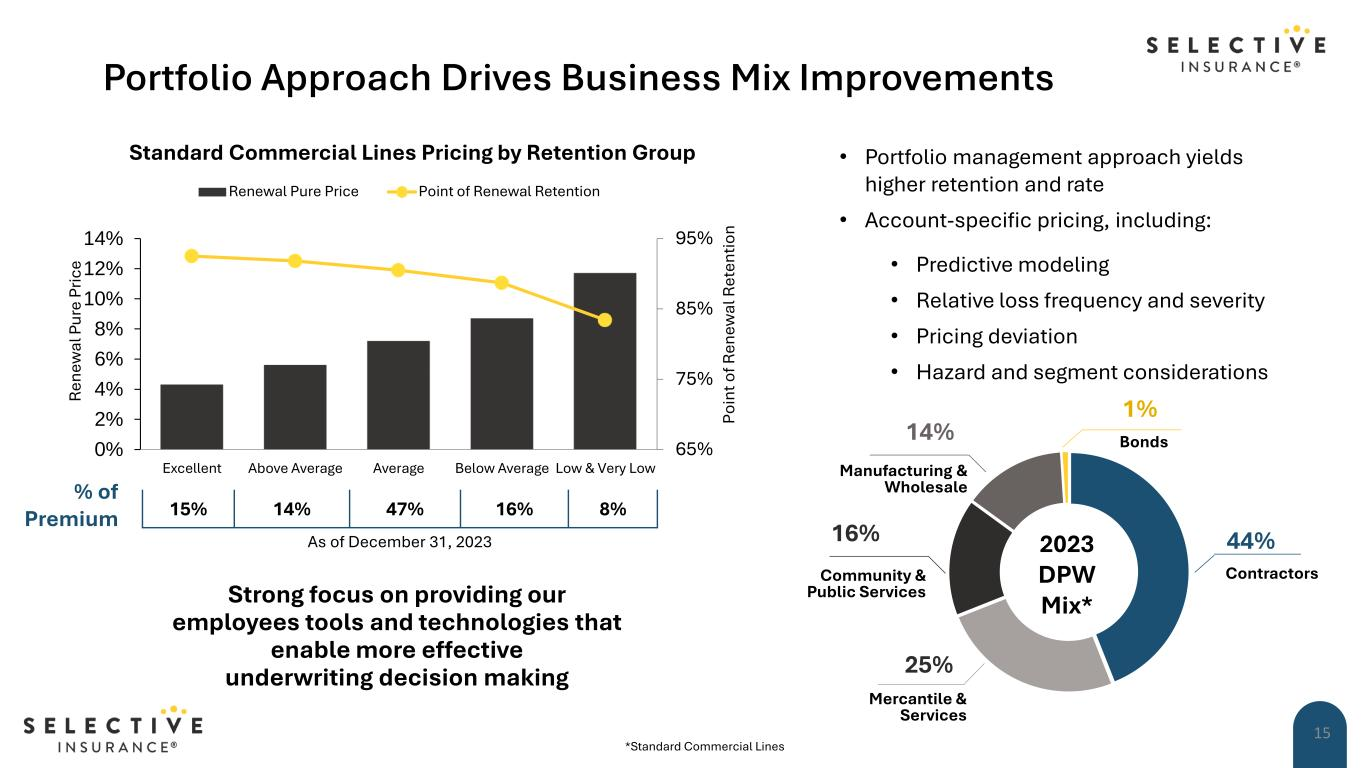

{
  "cls_name": "DocumentPresentation-v1",
  "slide": "The slide presents a portfolio approach to business mix improvements in the context of insurance, with a focus on standard commercial lines pricing by retention group and a breakdown of the 2023 DPW Mix by industry sectors.",
  "title": "Portfolio Approach Drives Business Mix Improvements",
  "page_number": 15,
  "plots": [
    {
      "cls_name": "Plot",
      "type": "bar",
      "title": "Standard Commercial Lines Pricing by Retention Group",
      "description": "A bar chart showing the renewal pure price for different retention groups categorized as Excellent, Above Average, Average, Below Average, and Low & Very Low. Each category also displays the percentage of premium and a line graph overlay showing the point of renewal retention.",
      "markdown": "| Retention Group | Renewal Pure Price | % of Premium | Point of Renewal Retention |\n| --- | --- | --- | --- |\n| Excellent | 6% | 15% | 85% |\n| Above Average | 8% | 14% | 

In [32]:
url = "https://www.sec.gov/Archives/edgar/data/230557/000023055724000007/sigifirstquarter2024inve015.jpg"
vlm_predict(url, "document.presentation")